In [1]:
import subprocess, os, shutil, ebf, sys
import numpy as np
import healpy as hp
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from scipy.optimize import minimize

import mwdust
import dustmaps
import ezpadova

In [2]:
import ssl
# Bypass SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
df_load = pd.read_csv('~/Desktop/training_data_isochrones.csv')

In [11]:
r = ezpadova.get_isochrones(
    logage=(5, 9, 0.5),
    MH=(-2.0, -2.0, 0.0),
    # Z=(0.0152, 0.0152, 0),
    photsys_file='gaiaEDR3'
)

Querying http://stev.oapd.inaf.it/cgi-bin/cmd...
Retrieving data...


In [12]:
df = ezpadova.resample_evolution_label(r)
df.columns

Index(['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe',
       'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2',
       'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn',
       'Xo', 'Cexcess', 'Z', 'mbolmag', 'Gmag', 'G_BPmag', 'G_RPmag', 'evol'],
      dtype='object')

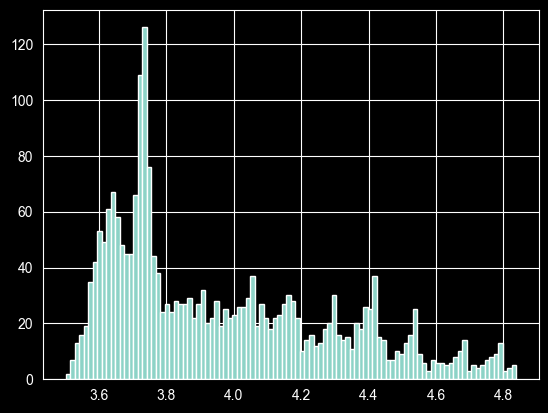

In [13]:
plt.hist(df.logTe, bins=100)
plt.show()

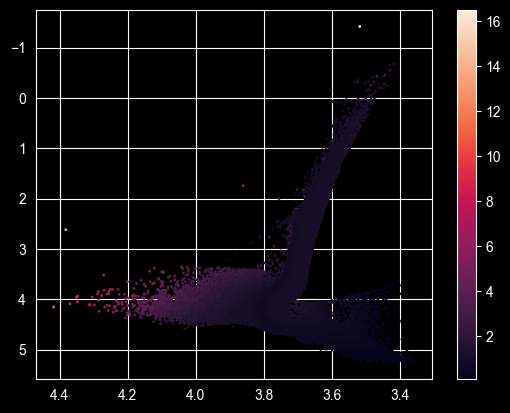

In [26]:
x_plt = df.logTe  #df.G_BPmag - df.G_RPmag
y_plt = df.logg
# plt.scatter(x_plt, y_plt, s=1, c=df.evol, cmap='viridis', zorder=10)
plt.scatter(df_load.teff_col, df_load.logg_col, s=1, zorder=9)

plt.colorbar()
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

# Try to infer quantities

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [27]:
df_load['log10_mass'] = np.log10(df_load.smass_col)

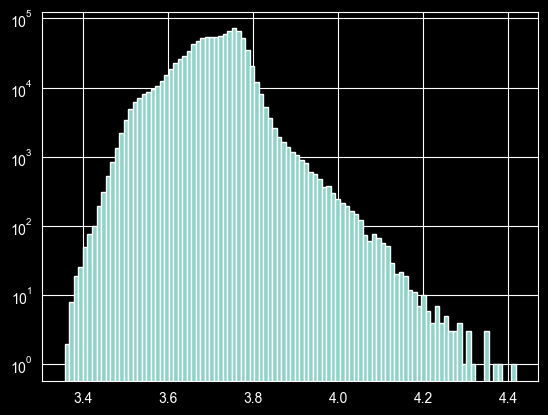

In [33]:
plt.hist(df_load.teff_col, bins=100, log=True);

In [34]:
X = df_load[['age_col', 'smass_col', 'feh_col']].values
y = df_load[['logg_col', 'teff_col']].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.transform(y_train)

# Train ML regression model

In [38]:
model = RandomForestRegressor(n_estimators=500, max_depth=None, n_jobs=-1).fit(X_train, y_train)

In [39]:
y_test_hat = scaler_y.inverse_transform(model.predict(X_test))

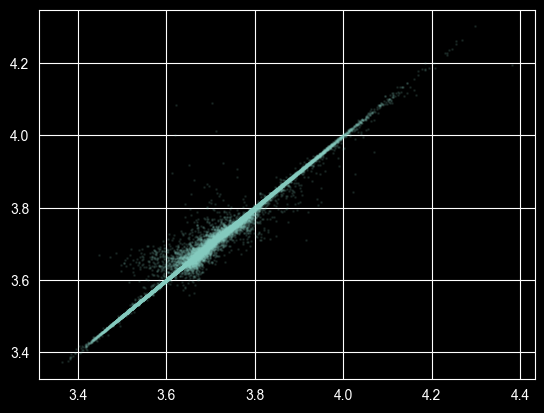

In [51]:
ax = 1
plt.scatter(y_test[:,ax], y_test_hat[:,ax], s=1, alpha=0.1)

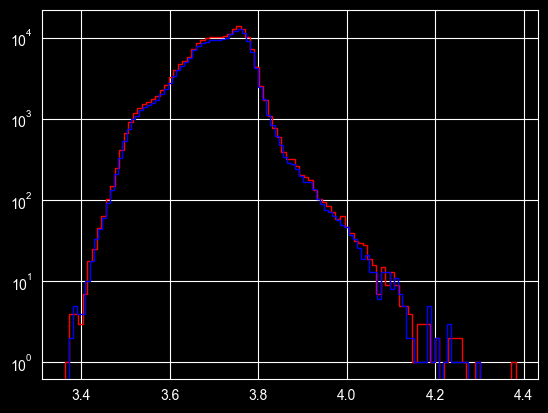

In [52]:
plt.hist(y_test[:,ax], bins=100, log=True, histtype='step', color='red')
plt.hist(y_test_hat[:,ax], bins=100, log=True, histtype='step', color='blue')
plt.show()

In [44]:
ax = 0
np.mean(np.sqrt((y_test[:,ax] - y_test_hat[:,ax])**2))

0.008726444578734643

In [ ]:
# Train

In [3]:
## Running galaxia in the command line. This will take some time (ca. 10min).
# Now we want to convert the ebf file to numpy files
path = os.path.abspath('../library/')
if path not in sys.path:
    sys.path.append(path)

In [57]:
%%time
# Here we create the folder where Galaxia will write the mock catalogue
nside = 16 # for extinction map and mollweide plot

################### All strings and float except for
outputFile = "GDR2mock_20.7Gmag"
modelFile = "Model/population_parameters_BGM_update.ebf"
codeDataDir = "/Users/ratzenboe/Documents/work/projects/galaxia-0.8.1_gedr3mock/GalaxiaData"
outputDir = '/Users/ratzenboe/Downloads/output/mock_cat_new'
photoSys = "parsec1/GAIADR2_TMASS"
magcolorNames = "gaia_g,gaia_gbp-gaia_grp"
appMagLimits0 = -1000
appMagLimits1 = 22.0
absMagLimits0 = -1000
absMagLimits1 = 1000
colorLimits0 = -1000
colorLimits1 = 1000
geometryOption = 0 #int
longitude = 0
latitude = 90
surveyArea = 1000
fSample = 0.0001
popID = -1 #int
warpFlareOn = 1 #int
seed = 1 #int
r_max = 1000
starType = 0 #int
photoError = 0 #int

folder_create = outputDir + '/'
if os.path.exists(folder_create):
    shutil.rmtree(folder_create)
    os.mkdir(folder_create)
    print(folder_create, "existed and was recreated")
else:
    os.mkdir(folder_create)
###################
# Creating the parameterfile
filedata = 'outputFile                          %s\nmodelFile                          %s\ncodeDataDir                          %s\noutputDir                           %s\nphotoSys                            %s\nmagcolorNames                       %s\nappMagLimits[0]                     %f\nappMagLimits[1]                     %f\nabsMagLimits[0]                     %f\nabsMagLimits[1]                     %f\ncolorLimits[0]                      %f\ncolorLimits[1]                      %f\ngeometryOption                      %d\nlongitude                           %f\nlatitude                            %f\nsurveyArea                          %f\nfSample                             %f\npopID                               %d\nwarpFlareOn                         %d\nseed                                %d\nr_max                               %f\nstarType                            %d\nphotoError                          %d\n' %(outputFile,modelFile,codeDataDir,outputDir,photoSys,magcolorNames,appMagLimits0,appMagLimits1,absMagLimits0,absMagLimits1,colorLimits0,colorLimits1,geometryOption,longitude,latitude,surveyArea,fSample,popID,warpFlareOn,seed,r_max,starType,photoError)
myparameterfile = outputDir + '/' + outputFile + '.log'
file = open(myparameterfile, "w")
file.write(filedata)
file.close()

/Users/ratzenboe/Downloads/output/mock_cat_new/ existed and was recreated
CPU times: user 622 μs, sys: 2.69 ms, total: 3.31 ms
Wall time: 7.41 ms


In [58]:
%%time
# Creating mock catalogue
args = ['galaxia', '-r', myparameterfile]
p = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print("Galaxia spawns catalogue")
(output, err) = p.communicate()
#p_status = p.wait()
print(output)

Galaxia spawns catalogue
b'Galaxia-v0.81\nCODEDATAPATH=/Users/ratzenboe/Documents/work/projects/galaxia-0.8.1_gedr3mock/GalaxiaData/\nReading Parameter file-             /Users/ratzenboe/Downloads/output/mock_cat_new/GDR2mock_20.7Gmag.log\n--------------------------------------------------------\noutputFile               GDR2mock_20.7Gmag       \nmodelFile                Model/population_parameters_BGM_update.ebf\ncodeDataDir              /Users/ratzenboe/Documents/work/projects/galaxia-0.8.1_gedr3mock/GalaxiaData\noutputDir                /Users/ratzenboe/Downloads/output/mock_cat_new\nphotoSys                 parsec1/GAIADR2_TMASS   \nmagcolorNames            gaia_g,gaia_gbp-gaia_grp\nappMagLimits[0]          -1000.000000            \nappMagLimits[1]          22.000000               \nabsMagLimits[0]          -1000.000000            \nabsMagLimits[1]          1000.000000             \ncolorLimits[0]           -1000.000000            \ncolorLimits[1]           1000.000000             

In [59]:
# Reading in the Catalogue and converting it to npy file. (If you added photometric bands then you will have to edit the convert routine)
bes = ebf.read(outputDir + "/" + outputFile + ".ebf",'/')

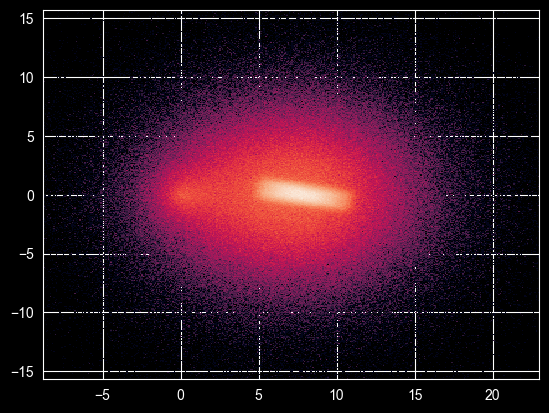

In [60]:
xplt, yplt = bes['px'], bes['py']
range_x, range_y = np.percentile(xplt, [0.1,99.9]), np.percentile(yplt, [0.1,99.9])
plt.hist2d(xplt, yplt, bins=400, range=(range_x, range_y), norm=LogNorm());

In [61]:
bes['px'].size/1e6

0.994441

In [62]:
filternames = ['tmass_j','tmass_h','tmass_ks','gaia_g','gaia_gbp','gaia_grp']
for band in filternames:
    bes[band] += 5 * np.log10(bes['rad']*1000.) - 5

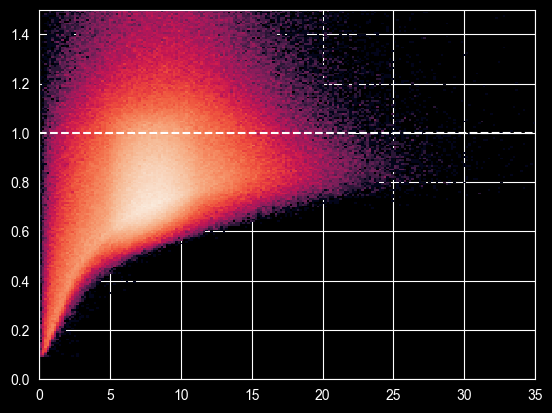

In [63]:
plt.hist2d(bes['rad'], bes['smass'], bins=200, norm=LogNorm(), range=[(0, 35), (0, 1.5)])
plt.axhline(1, ls='--', c='white')

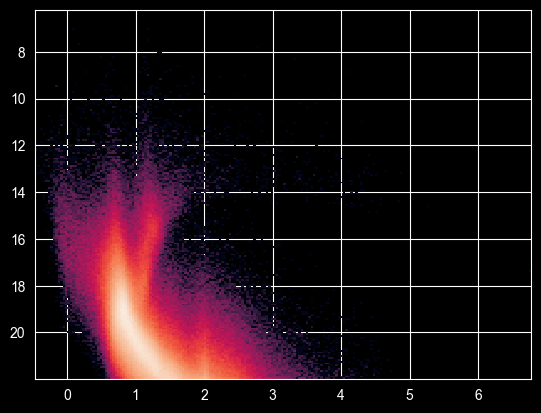

In [64]:
plt.hist2d(bes['gaia_gbp'] - bes['gaia_grp'], bes['gaia_g'], bins=200, norm=LogNorm())
plt.gca().invert_yaxis();

In [65]:
# We add ra and dec
c = SkyCoord(b=bes['glat'], l=bes['glon'], frame = 'galactic', unit=(u.deg, u.deg))
ra = c.icrs.ra.deg
dec = c.icrs.dec.deg

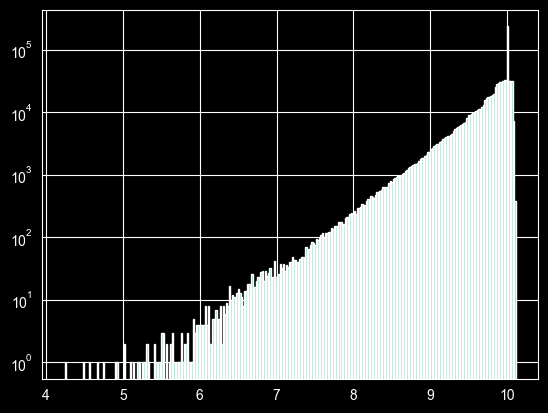

In [66]:
plt.hist(bes['age'], bins=300, log=True);

5845 stars younger than 8
782 stars younger than 7
73 stars younger than 6


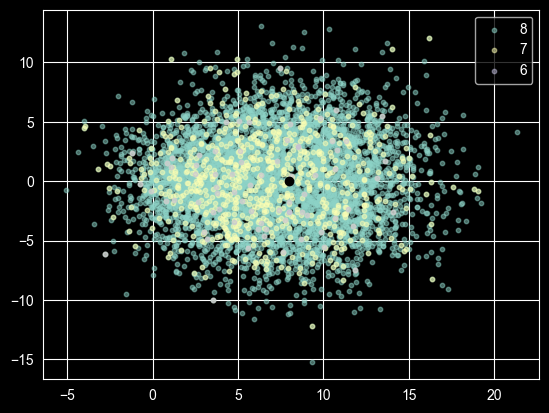

In [67]:
xplt, yplt = bes['px'], bes['py']

for age_cutoff in [6, 7, 8][::-1]:
    cut = bes['age']<age_cutoff
    plt.scatter(xplt[cut], yplt[cut], s=10, alpha=0.5, label=f'{age_cutoff}')
    print(f'{np.sum(cut)} stars younger than {age_cutoff}')
plt.scatter(8, 0, c='k')
plt.legend()

total number of stars = 9944410000
0.0
9944410000.002218
740533476.8382133


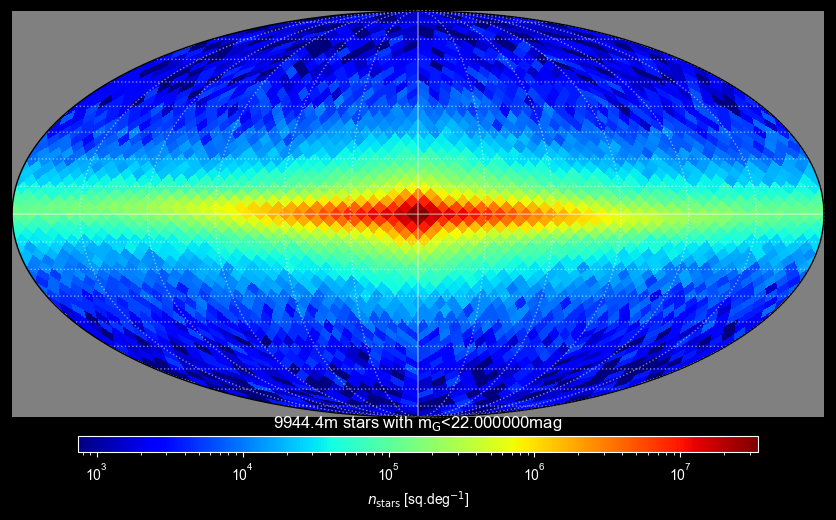

In [68]:
### Plot the stellar density across the sky
## Using plotting routines from Tri Astraatmadja

NSIDE = nside
oversampling = 1./fSample
total = len(bes['px'])
glon = bes['glon'] * (np.pi/180.)
glat = (90.-bes['glat']) * (np.pi/180.)
print('total number of stars = %.d' %(total * oversampling))
count = hp.ang2pix(NSIDE, glat, glon)
sqdegs = 41253
pixels = NSIDE * NSIDE * 12
pixel_per_sqdeg = pixels / float(sqdegs)
min_density = oversampling * pixel_per_sqdeg
m = np.arange(hp.nside2npix(NSIDE))
density = np.zeros(hp.nside2npix(NSIDE))
for item in count:
    density[item] += oversampling * pixel_per_sqdeg
print(np.min(density))
print(sum(density)/pixel_per_sqdeg)
print(sum(density))
cmap = cm.jet
# cmap.set_under(cmap(0.0))
# cmap.set_over(cmap(1.0))
norm=LogNorm()
minVal = np.nanmin(density[density>0])
maxVal = np.nanmax(density[density<+np.inf])
density[density<minVal] = minVal
# bes['glon'] = bes['glon'] * (180./np.pi)
cbLabel=r'$n_{\rm stars}$ [sq.deg$^{-1}$]'
hp.mollview(density, unit=cbLabel, min=minVal, max=maxVal, nest=False, title='', norm=norm, cmap=cmap, cbar=None)
fig = plt.gcf()
ax = plt.gca()
pos1 = ax.get_position() # get the original position
pos2 = [pos1.x0, pos1.y0 + 0.06,  pos1.width, pos1.height]
ax.set_position(pos2) # set a new position
im = ax.get_images()[0]
cbAx = fig.add_axes([0.1, 0.12, 0.8, 0.03])
cb = plt.colorbar(im, cax=cbAx, orientation='horizontal', )
cb.ax.minorticks_on()
# tickMarks = getLogTickMarks(minVal, maxVal)
# minorticks = im.norm(tickMarks)
# cb.ax.xaxis.set_ticks(minorticks, minor=True)
cb.solids.set_edgecolor("face")
cb.set_label(cbLabel)
plt.title(r"%.1fm stars with m$_\mathrm{G}$<%fmag" %(total*oversampling/1e6,appMagLimits1), fontsize = 12)
hp.graticule(dpar=10, dmer=30, color='white', alpha=0.5)
plt.show()

# Fit broken power law to magnitude distribution

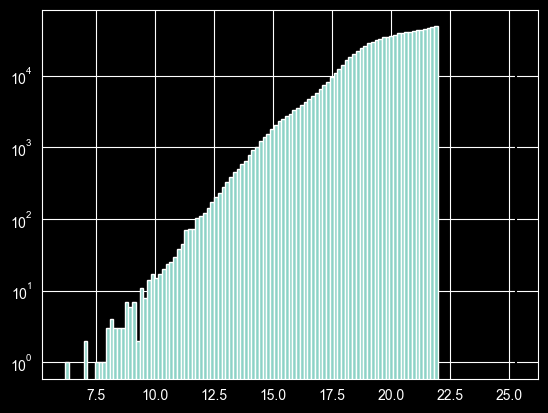

In [69]:
plt.hist(bes['gaia_g'], bins=100, log=True)
plt.axvline(25.3, c='k')

In [101]:
def _exp_int(a, b, beta, tol=1e-10):
    """Integral of exp(-beta m) dm from a to b, with a safe beta≈0 fallback."""
    if abs(beta) < tol:
        return b - a
    return (np.exp(-beta*a) - np.exp(-beta*b)) / beta

def _norm_2break_exp(mmin, mb1, mb2, mmax, b1, b2, b3):
    """Normalization constant C for the 2-break exponential."""
    left  = _exp_int(mmin, mb1, b1)
    mid   = np.exp((b2 - b1)*mb1)            * _exp_int(mb1, mb2, b2)
    right = np.exp((b2 - b1)*mb1 + (b3 - b2)*mb2) * _exp_int(mb2, mmax, b3)
    Z = left + mid + right
    return 1.0 / Z

def _logpdf_2break_exp(m, mmin, mb1, mb2, mmax, b1, b2, b3):
    """Log-pdf for samples m under normalized 2-break exponential."""
    C = _norm_2break_exp(mmin, mb1, mb2, mmax, b1, b2, b3)
    out = np.full_like(m, -np.inf, dtype=float)
    s1 = (m >= mmin) & (m < mb1)
    s2 = (m >= mb1) & (m < mb2)
    s3 = (m >= mb2) & (m <= mmax)
    out[s1] = np.log(C) - b1*m[s1]
    out[s2] = np.log(C) + (b2 - b1)*mb1 - b2*m[s2]
    out[s3] = np.log(C) + (b2 - b1)*mb1 + (b3 - b2)*mb2 - b3*m[s3]
    return out

def _softplus(z, beta=1.0):
    return np.log1p(np.exp(beta*z))/beta

def _unpack_params_breaks(z, mmin, mmax):
    """
    Reparameterize breaks to guarantee mmin < mb1 < mb2 < mmax.

    z = [zb1, zgap]; mb1 via sigmoid in (mmin, mmax);
    mb2 = mb1 + sigmoid(zgap)*(mmax - mb1).
    """
    zb1, zgap = z
    L = mmax - mmin
    t1 = 1.0/(1.0 + np.exp(-zb1))      # in (0,1)
    mb1 = mmin + t1 * L
    mb1 = np.clip(mb1, np.nextafter(mmin, mmax), np.nextafter(mmax, mmin))
    u  = 1.0/(1.0 + np.exp(-zgap))     # in (0,1)
    mb2 = mb1 + u * (mmax - mb1)
    mb2 = np.clip(mb2, np.nextafter(mb1, mmax), np.nextafter(mmax, mmin))
    return mb1, mb2

def fit_two_break_exp_unbinned(m, mmin=None, mmax=None,
                               beta0=(0.6, 0.3, 0.8),  # initial slopes
                               mb1_init=None, mb2_frac=0.6):
    """
    Fit a continuous 2-break exponential p(m) ∝ exp(-β_i m) to raw magnitudes m by MLE.

    beta0: initial (beta1, beta2, beta3); can be any real numbers.
    mb1_init: initial first break (defaults to median(m)).
    mb2_frac: initial fraction between mb1 and mmax for mb2 (0<u<1).
    """
    m = np.asarray(m, float)
    if mmin is None: mmin = np.min(m)
    if mmax is None: mmax = np.max(m)
    if mb1_init is None: mb1_init = np.median(m)
    mb2_init = mb1_init + mb2_frac*(mmax - mb1_init)

    # Unconstrained optimization variables: slopes b1,b2,b3 (free), zb1, zgap (free)
    b1_0, b2_0, b3_0 = beta0
    # map initial breaks to z-space
    t1  = (mb1_init - mmin) / (mmax - mmin); t1 = np.clip(t1, 1e-6, 1-1e-6)
    zb1_0 = np.log(t1) - np.log1p(-t1)
    u   = (mb2_init - mb1_init) / (mmax - mb1_init); u = np.clip(u, 1e-6, 1-1e-6)
    zgap_0 = np.log(u) - np.log1p(-u)
    z0 = np.array([b1_0, b2_0, b3_0, zb1_0, zgap_0], float)

    def nll(z):
        b1, b2, b3, zb1, zgap = z
        mb1, mb2 = _unpack_params_breaks([zb1, zgap], mmin, mmax)
        lp = _logpdf_2break_exp(m, mmin, mb1, mb2, mmax, b1, b2, b3)
        if not np.all(np.isfinite(lp)):
            return 1e50
        return -np.sum(lp)

    res = minimize(nll, z0, method="L-BFGS-B")
    b1, b2, b3, zb1, zgap = res.x
    mb1, mb2 = _unpack_params_breaks([zb1, zgap], mmin, mmax)
    return {"beta1": b1, "beta2": b2, "beta3": b3,
            "m_break1": mb1, "m_break2": mb2,
            "mmin": mmin, "mmax": mmax,
            "success": bool(res.success), "fun": float(res.fun)}

In [71]:
def plot_two_break_exp_fit(m, fit, bins=50, logy=False, ax=None, color="C0"):
    """
    Plot histogram of magnitudes and the fitted 2-break exponential model.

    Parameters
    ----------
    m : array-like
        Magnitude samples.
    fit : dict
        Output from `fit_two_break_exp_unbinned`.
        Must contain beta1, beta2, beta3, m_break1, m_break2, mmin, mmax.
    bins : int or sequence
        Number of histogram bins or explicit bin edges.
    logy : bool
        If True, use a log y-axis.
    ax : matplotlib.axes.Axes or None
        Optional existing Axes to plot on.
    color : str
        Line color for the model curve.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The Axes with the plot.
    """

    # Extract parameters
    b1, b2, b3 = fit["beta1"], fit["beta2"], fit["beta3"]
    mb1, mb2 = fit["m_break1"], fit["m_break2"]
    mmin, mmax = fit["mmin"], fit["mmax"]

    # Define normalized PDF
    def exp_int(a, b, beta, tol=1e-10):
        if abs(beta) < tol:
            return b - a
        return (np.exp(-beta*a) - np.exp(-beta*b)) / beta

    def norm_const():
        left  = exp_int(mmin, mb1, b1)
        mid   = np.exp((b2 - b1)*mb1) * exp_int(mb1, mb2, b2)
        right = np.exp((b2 - b1)*mb1 + (b3 - b2)*mb2) * exp_int(mb2, mmax, b3)
        return 1.0 / (left + mid + right)

    C = norm_const()

    def pdf(m):
        m = np.asarray(m)
        p = np.zeros_like(m, dtype=float)
        s1 = (m >= mmin) & (m < mb1)
        s2 = (m >= mb1) & (m < mb2)
        s3 = (m >= mb2) & (m <= mmax)
        p[s1] = C * np.exp(-b1*m[s1])
        p[s2] = C * np.exp((b2 - b1)*mb1 - b2*m[s2])
        p[s3] = C * np.exp((b2 - b1)*mb1 + (b3 - b2)*mb2 - b3*m[s3])
        return p

    # Create figure/axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # Histogram (density)
    counts, edges, _ = ax.hist(m, bins=bins, density=True,
                               histtype="stepfilled", alpha=0.4,
                               color="grey", label="data")

    # Model curve
    mm = np.linspace(mmin, mmax, 500)
    ax.plot(mm, pdf(mm), color=color, lw=2, label="fit", ls='--')

    # Break lines
    ax.axvline(mb1, ls="--", color=color, lw=1.5, alpha=0.7)
    ax.axvline(mb2, ls="--", color=color, lw=1.5, alpha=0.7)

    # Labels and cosmetics
    ax.set_xlabel("Magnitude")
    ax.set_ylabel("Normalized density")
    if logy:
        ax.set_yscale("log")
    ax.legend(frameon=False)
    ax.set_xlim(mmin, mmax)
    ax.set_title(
        f"Broken Exponential Fit:\n"
        rf"$\beta_1={b1:.3f},\,\beta_2={b2:.3f},\,\beta_3={b3:.3f}$"
        "\n"
        rf"$m_{{b1}}={mb1:.3f},\,m_{{b2}}={mb2:.3f}$"
    )

    return ax

In [72]:
x = bes['gaia_g']

In [73]:
res_u = fit_two_break_exp_unbinned(x[x<25], mmin=None, mmax=None,
                               beta0=(0.6, 0.3, 0.8),  # initial slopes
                               mb1_init=19, mb2_frac=0.5)


#(x[x<25.3], xmin=np.min(x), xmax=25.3, #np.max(x),
                               # x0=(1.4, 2.2, 3.1, np.median(x[x<25.3]), 0.5))
print(res_u)

{'beta1': -0.7495505439051674, 'beta2': -0.34943419031045136, 'beta3': -0.1549455359887821, 'm_break1': 18.71402545947018, 'm_break2': 19.682689019180476, 'mmin': 6.200684070587158, 'mmax': 21.999998092651367, 'success': True, 'fun': 1699365.0251975372}


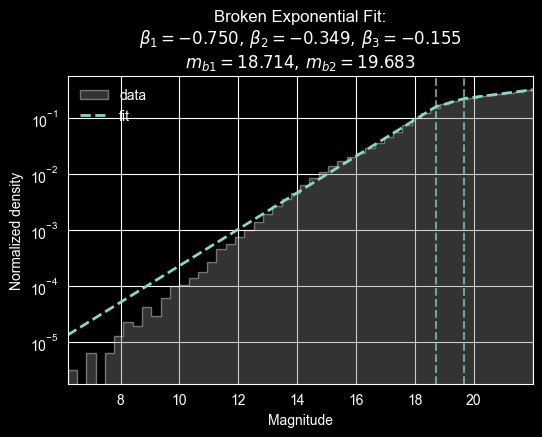

In [74]:
# Plot
ax = plot_two_break_exp_fit(x[x<25], res_u, bins=50, logy=True)
plt.show()

In [75]:
bes.keys()

dict_keys(['log', 'px', 'py', 'pz', 'vx', 'vy', 'vz', 'feh', 'alpha', 'smass', 'age', 'rad', 'mag0', 'mag1', 'mag2', 'popid', 'satid', 'fieldid', 'partid', 'center', 'lum', 'teff', 'grav', 'mact', 'mtip', 'gaia_g', 'gaia_gbp', 'gaia_grp', 'tmass_j', 'tmass_h', 'tmass_ks', 'label', 'exbv_schlegel', 'exbv_solar', 'exbv_schlegel_inf', 'glon', 'glat'])

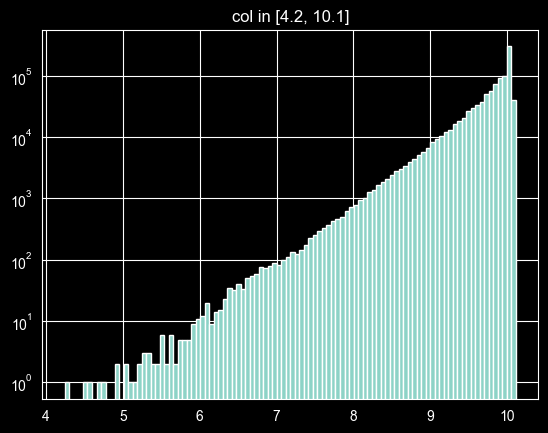

In [76]:
col = 'age'
plt.hist(bes[col], bins=100, log=True)
plt.title(f'col in [{bes[col].min():.1f}, {bes[col].max():.1f}]')
plt.show()

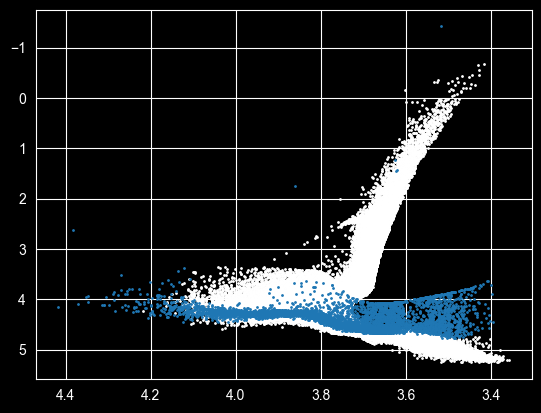

In [77]:
xcol = 'teff'
ycol = 'grav'
colcol = 'age'
cut = bes['age'] < 8
# plt.hist2d(bes[xcol], bes[ycol], bins=100, norm=LogNorm(0.1)) #, log=True)
plt.scatter(bes[xcol][~cut], bes[ycol][~cut], c='white', s=1) #c=bes[colcol][~cut], s=1)
plt.scatter(bes[xcol][cut], bes[ycol][cut], c='tab:blue', s=1) #bes[colcol][cut], s=1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

In [78]:
type(bes[xcol])

numpy.ndarray

In [108]:
cols_dict = dict(
    teff_col = 'teff',
    logg_col = 'grav',
    age_col = 'age',
    feh_col = 'feh',
    rad_col = 'rad',
    lum_col = 'lum',
    # alpha_col = 'alpha',
    smass_col = 'smass',
    mact_col = 'mact',
    mtip_col = 'mtip'
)

In [96]:
# plt.scatter(bes[smass_col], bes[mtip_col], s=1)
# plt.show()

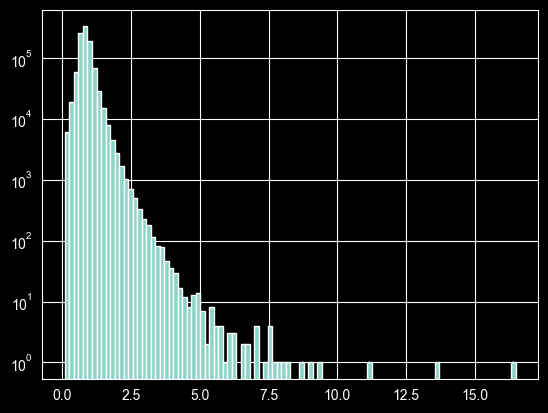

In [100]:
plt.hist(bes[smass_col], bins=100, log=True)
plt.show()

In [109]:
df = pd.DataFrame(data=np.vstack([bes[c] for c in cols_dict.values()]).T, columns=cols_dict.keys())

In [111]:
# df.to_csv('~/Desktop/training_data_isochrones.csv', index=False)

In [73]:
def gal_to_healpix(glon_deg, glat_deg, nside, nest=False):
    """
    Map Galactic lon/lat (deg) to HEALPix pixel indices.

    Parameters
    ----------
    glon_deg, glat_deg : array-like
        Galactic longitude [0,360) and latitude [-90,90] in degrees.
    nside : int
        HEALPix NSIDE (power of 2).
    nest : bool
        If True, return NESTED pixel indices; otherwise RING.

    Returns
    -------
    pix : np.ndarray (int)
        Pixel index for each input point.
    """
    glon = np.asarray(glon_deg, dtype=float) % 360.0                # wrap to [0,360)
    glat = np.asarray(glat_deg, dtype=float)

    theta = np.deg2rad(90.0 - glat)                                 # co-latitude
    phi   = np.deg2rad(glon)                                        # longitude
    pix = hp.ang2pix(nside, theta, phi, nest=nest)
    return pix

def group_indices_by_pixel(pix, nside):
    """
    Return a dict {pixel_id: np.ndarray of row indices} and a count map.
    """
    pix = np.asarray(pix, dtype=np.int64)
    npix = hp.nside2npix(nside)

    # counts per pixel (length = npix)
    counts = np.bincount(pix, minlength=npix)

    # group indices efficiently
    order = np.argsort(pix)
    pix_sorted = pix[order]
    splits = np.flatnonzero(np.diff(pix_sorted)) + 1
    groups = np.split(order, splits)  # each is indices into original array

    # build dict only for non-empty pixels
    unique_pix = np.unique(pix_sorted)
    by_pixel = {int(p): idxs for p, idxs in zip(unique_pix, groups)}
    return by_pixel, counts


def reduce_to_healpix_map(pix, values, nside, reducer="mean", fill=np.nan):
    """
    Aggregate `values` per pixel into a HEALPix map.
    reducer: "mean", "median", "sum", "min", "max"
    """
    import numpy as np
    import healpy as hp

    pix = np.asarray(pix, int)
    vals = np.asarray(values, float)
    npix = hp.nside2npix(nside)
    by_pixel, counts = group_indices_by_pixel(pix, nside)

    out = np.full(npix, fill, float)
    for p, idx in by_pixel.items():
        v = vals[idx]
        if reducer == "mean":   out[p] = v.mean()
        elif reducer == "median": out[p] = np.median(v)
        elif reducer == "sum":  out[p] = v.sum()
        elif reducer == "min":  out[p] = v.min()
        elif reducer == "max":  out[p] = v.max()
        else:
            raise ValueError("Unknown reducer.")
    return out

def plt_healpix_galacitc(glon, glat, data, nside=32, reducer="mean", fill=np.nan, title=''):
    pix = gal_to_healpix(glon, glat, nside=nside, nest=False)
    hmap = reduce_to_healpix_map(pix, data, nside, reducer=reducer, fill=fill)
    hp.mollview(hmap, title=title, cmap=cm.viridis, nest=False, coord=['G'])  # 'G' = Galactic
    hp.graticule(dpar=10, dmer=30, color='white', alpha=0.5)
    plt.show()

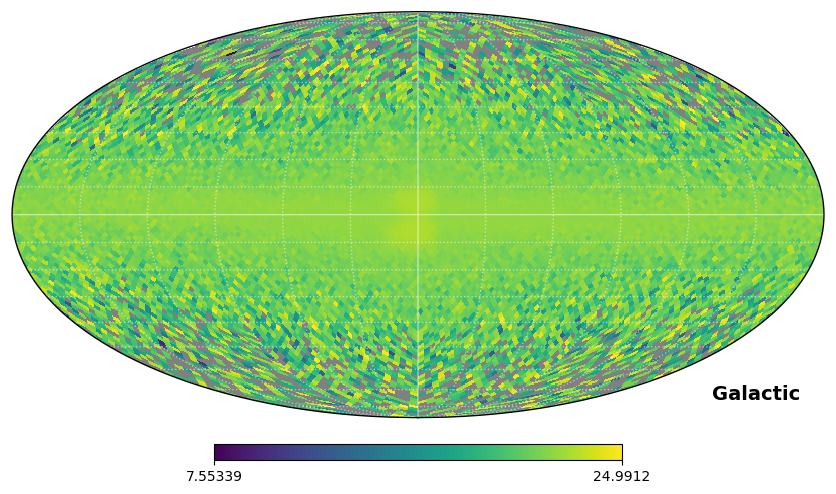

In [74]:
plt_healpix_galacitc(bes['glon'], bes['glat'], bes['gaia_g'], nside=32)

In [24]:
# Example:
ns = 16
pix = gal_to_healpix(bes['glon'], bes['glat'], nside=ns, nest=False)
by_pixel, counts = group_indices_by_pixel(pix, nside=ns)

In [1]:
plt.hist(np.log10(counts+1), bins=100)
plt.show();

NameError: name 'plt' is not defined

# Enter Gaia selection function

In [28]:
from gaiaunlimited.selectionfunctions import DR3SelectionFunctionTCG
from gaiaunlimited.utils import get_healpix_centers

Status messages could not be retrieved


In [29]:
mapHpx7 = DR3SelectionFunctionTCG()

In [30]:
coords_of_centers = get_healpix_centers(5)

In [31]:
completeness = mapHpx7.query(c, bes['gaia_g'])

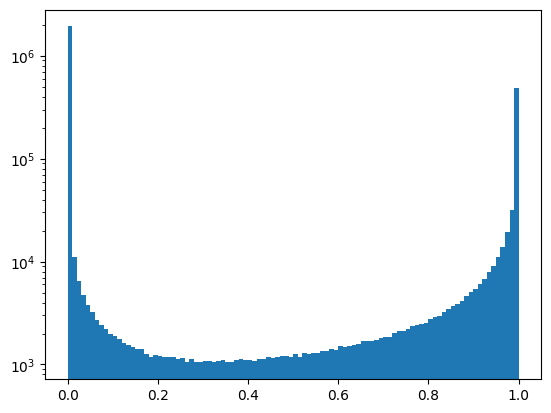

In [38]:
plt.hist(completeness, bins=100, log=True);

In [39]:
is_observed = completeness > np.random.uniform(size=bes['gaia_g'].size)

In [40]:
np.sum(is_observed)/completeness.size

0.24857373504931754

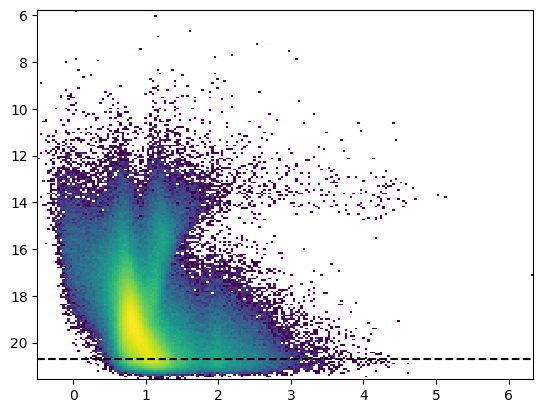

In [41]:
xplt = (bes['gaia_gbp'] - bes['gaia_grp'])[is_observed]
yplt = bes['gaia_g'][is_observed]

plt.hist2d(xplt, yplt, bins=200, norm=LogNorm())
plt.axhline(20.7, color='k', ls='--')
plt.gca().invert_yaxis();

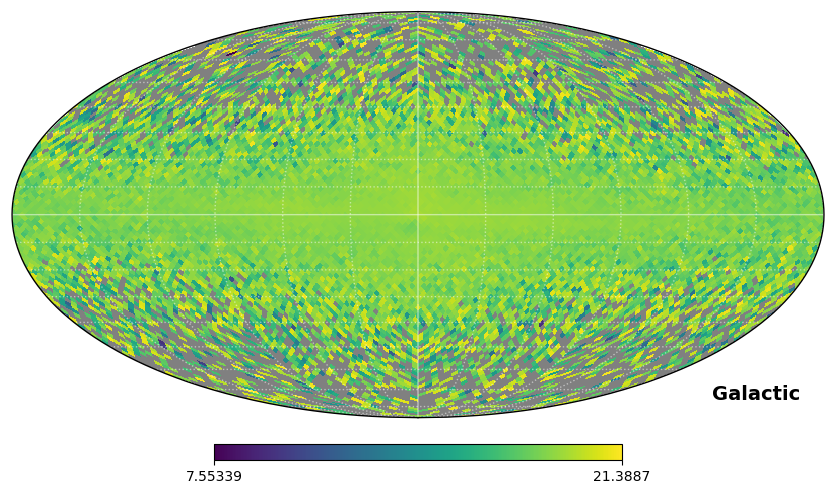

In [77]:
plt_healpix_galacitc(bes['glon'][is_observed], bes['glat'][is_observed], bes['gaia_g'][is_observed], nside=32)

In [45]:
from dustmaps import bayestar
from mwdust import Combined19

In [47]:
com19 = Combined19()

In [60]:
Av = com19(bes['glon'][is_observed], bes['glat'][is_observed], bes['rad'][is_observed])
plt.hist(Av, bins=100);

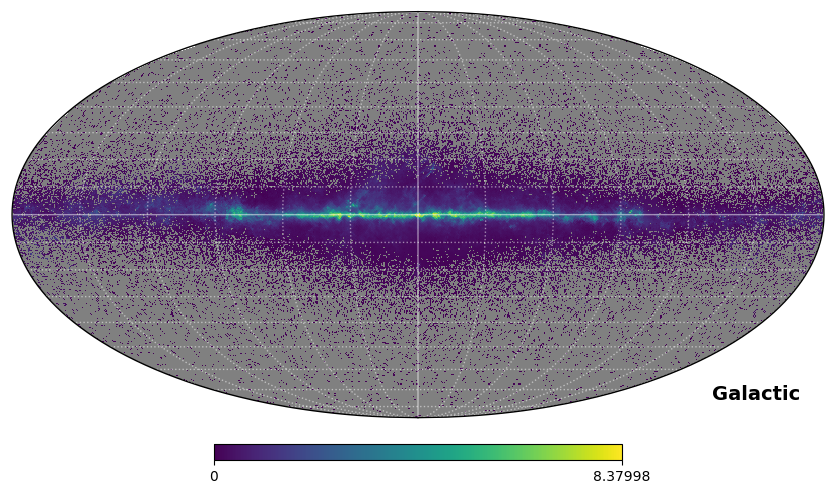

In [80]:
plt_healpix_galacitc(bes['glon'][is_observed], bes['glat'][is_observed], Av, nside=128)f